In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz, square
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pdb
# set the seed
np.random.seed(2)

## Match filter on regular sampling:
* Since we have a regular sampling there is no problem with the frequencies of the dictionary or the nyquist frequency, this allow us to use an easy procedure for the match filter method for the fourier dictionary and with this, we will use the fast fourier algorithm.

## Cases
* We are going to consider different cases in order to see how this method will work, this cases are:
    * Signal only of white noise
    * Signal of a sinusoid plus white noise
    * Signal of a composition of sinusoids plus white noise

## Creating the signal

In [2]:
# this method is implemented in file createSignal.py of core package
from core.createSignal import *

## Whitening method:
* Some signals could be "colored", which means, that there is a noise fluctuaction much larger in some parts, in order to supress this extra fluctuation in noise, we do the "whitening", this allows us to see weak signals that before we couldn't see.

    To "whiten" a signal we divide it by the noise amplitude spectrum, in the fourier domain. And the resulting time series change his units to "sigmas" away from the mean.
    
    One simple example is a signal of only noise, this rough signal of noise could be misunderstood if we do not clear the high noises, this will be seen on the case 1.

In [3]:
# this method is implemented in file whitening.py of core package
from core.whitening import *

## The Match Filter method:
The idea is to make the convolution between the signal and a template, using the fourier transform allow us to make easy the convolution. The procedure is:
* First make the fourier transform of the signal and template
* do the product and scale for the power spectral density of the noise
* then go back to the time domain in order to se how is the SNR for different matches across time.
* find the best SNR, i.e. the SNR when the template and the signal match the best while we are "moving" the template across time.



This calculation is described in section IV of: FINDCHIRP: An algorithm for detection of gravitational waves from inspiraling compact binaries B. Allen et al., PHYSICAL REVIEW D 85, 122006 (2012) ; http://arxiv.org/abs/gr-qc/0509116

In [4]:
# Match_filter
from core.matchFilter import *

### Testing for White noise
* No matter what template whe try here there should be always a bad SNR. This is like a basic case for the theory.

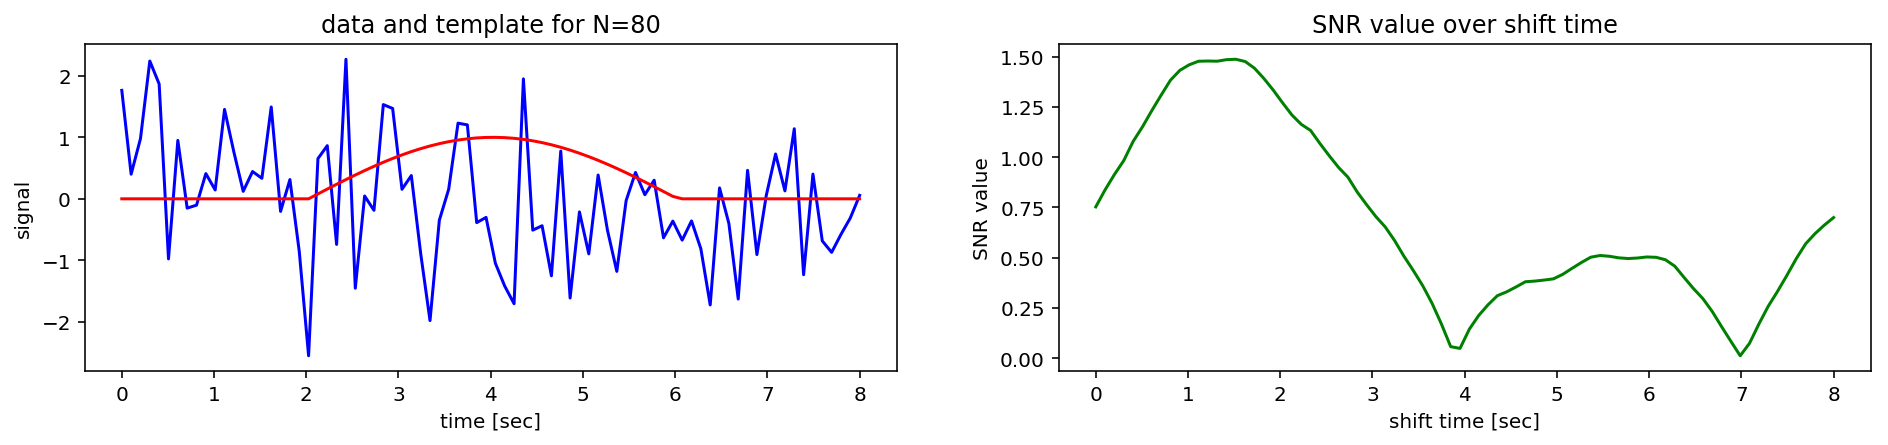

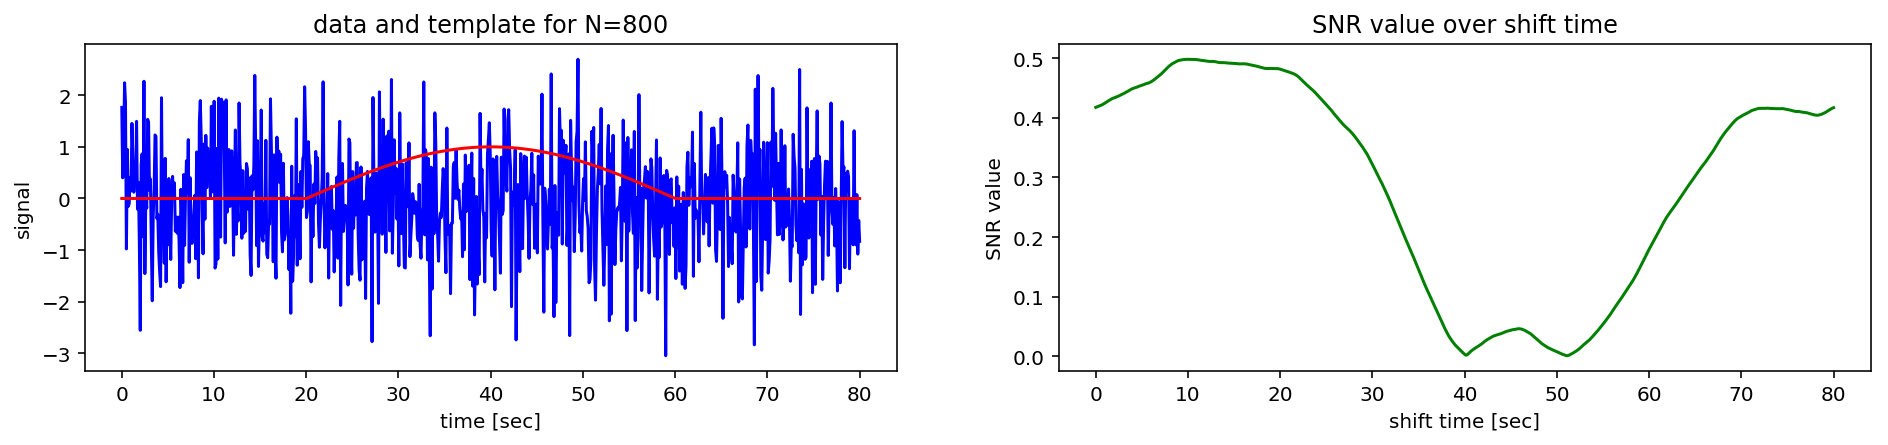

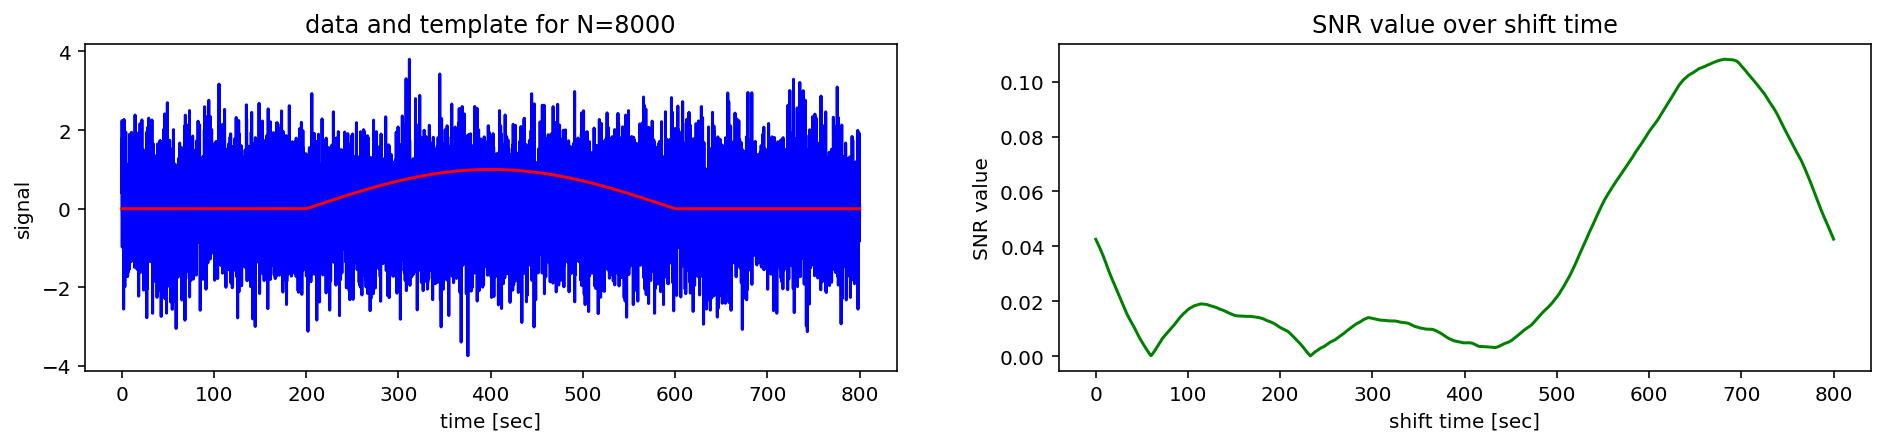

In [41]:

def data_noisy(N, seed=0, dt=0.1):
    T = N * dt       # duration [s]
    np.random.seed(seed) # set the seed
    # time array
    times = np.linspace(0, N * dt, N)

    # generate the noise
    noise =  np.random.normal(0, 1, len(times))

    # here the signal is noise
    return noise, times

def get_template(times, freqs, ws):
    l = len(times)
    # generate the template
    template = np.zeros(l)
    
    # two options to check template, one completely sinusoidal and another with just one peak
    # one peak
    template[int(l*1/4): int(l*3/4)] = Signal(frequencies=freqs, weights=ws).sin_samples(times[0:int(l*2/4)], 
                                                                                         with_noise=False)

    # completely sinusoidal
    # template = Signal(frequencies=[low_f, 300], weights=[0.9, 0.1]).sin_samples(times, with_noise=False)
    return template

# do the match filter
def match(data, template, dt, do_plot=True, shift=False, normalize=True, axis=None, label="SNR"):
    mf = MatchFilter(data, template, dt)
    snr = mf.SNR(data, normalize=normalize, shift=shift)
    if do_plot:
        plot_matchFilter(times, data, template, snr, shift=shift, axis=axis, label=label)
    return snr
        
def plot_matchFilter(times, data, template, snr, shift=False, axis=None, label="SNR"):
    if axis is not None:
        ax1 = axis[0]
        ax2 = axis[1]
    else:
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 3))
    ax1.plot(times, data, 'b')
    ax1.plot(times, template, 'r')
    if shift:
        ax2.plot(times - times[int(len(times)/2)], snr, 'g', label=label)
    else:
        ax2.plot(times, snr, 'g')
    ax1.set_title("data and template for N={}".format(len(times)))
    ax1.set_xlabel("time [sec]")
    ax1.set_ylabel("signal")
    ax2.set_title("SNR value over shift time")
    ax2.set_xlabel("shift time [sec]")
    ax2.set_ylabel("SNR value")

dt = 0.1
N = 80
data, times = data_noisy(N, dt=dt)
template = get_template(times, [1 / (N * dt)], [1])
snr = match(data, template, dt)

N = 800
data, times = data_noisy(N, dt=dt)
template = get_template(times, [1 / (N * dt)], [1])
snr = match(data, template, dt)

N = 8000
data, times = data_noisy(N, dt=dt)
template = get_template(times, [1 / (N * dt)], [1])
snr = match(data, template, dt)

### Comments (in spanish)
* primero recalcar que estoy repitiendo la implementacion hecha por la gente de ligo (https://losc.ligo.org/s/events/GW150914/LOSC_Event_tutorial_GW150914.html), ignoro si su implementacion tiene alguna suposicion implicita que me afecte a los datos. Estoy trabajando en una implementacion mia siguiendo el algoritmo FINDCHIRP pero modificado para caso de sampleo irregular que aun no esta lista.
* entonnces, de lo realizado arriba, intento el match de un template sinusoidal (solo un peak) con una señal de ruido, segun entiendo para estos casos en promedio el SNR deberia estar normalizado a algo similar a raiz cuadrada de 2 lo cual no ocurre, ademas mientras mas datos mas baja la SNR. Tambien lo intento para el caso de usar tanto template como señal solo ruido, esto no tiene mucho sentido, pero el valor que obtengo es:

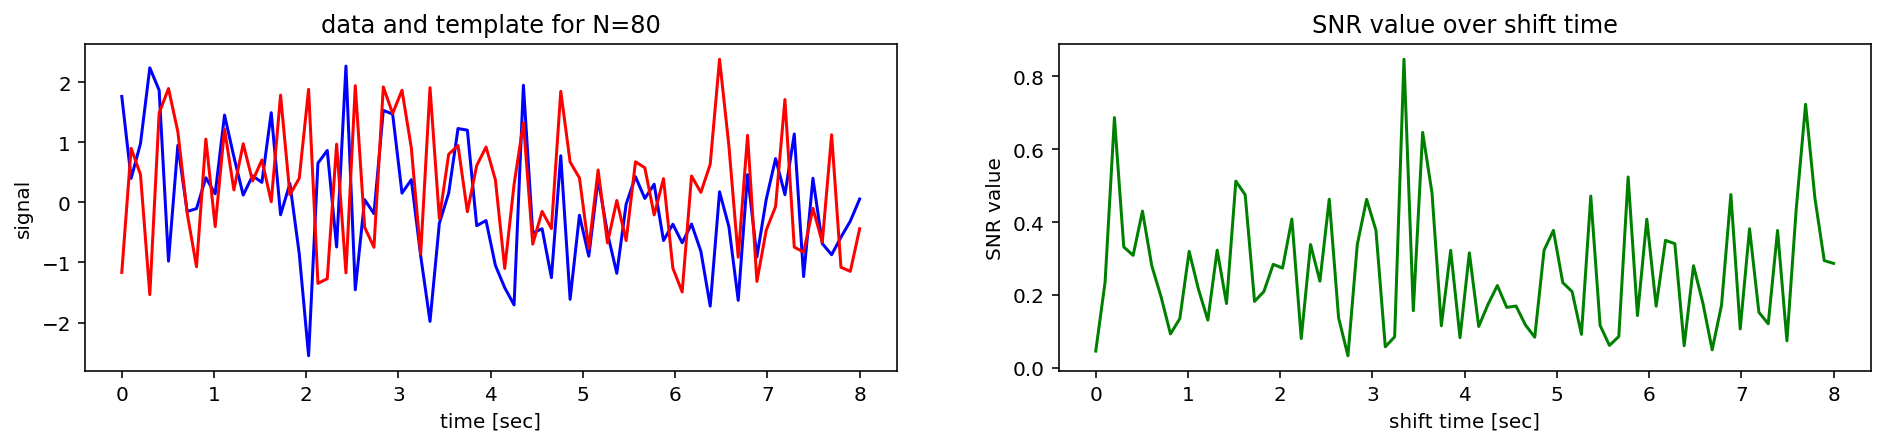

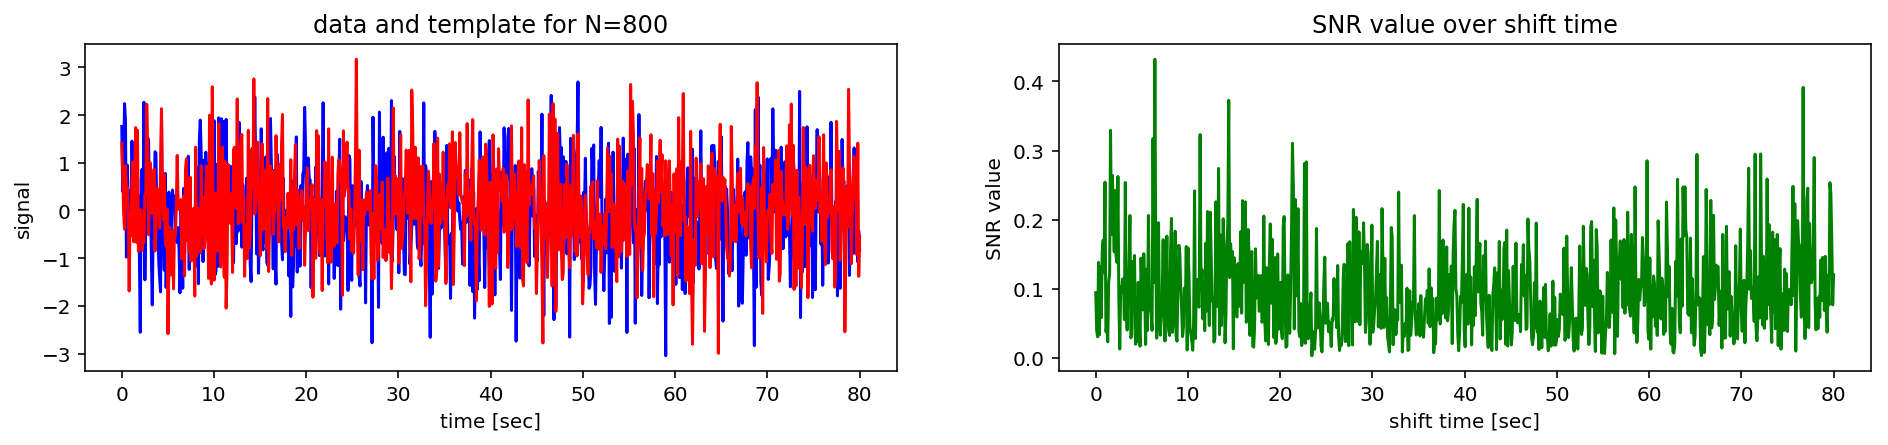

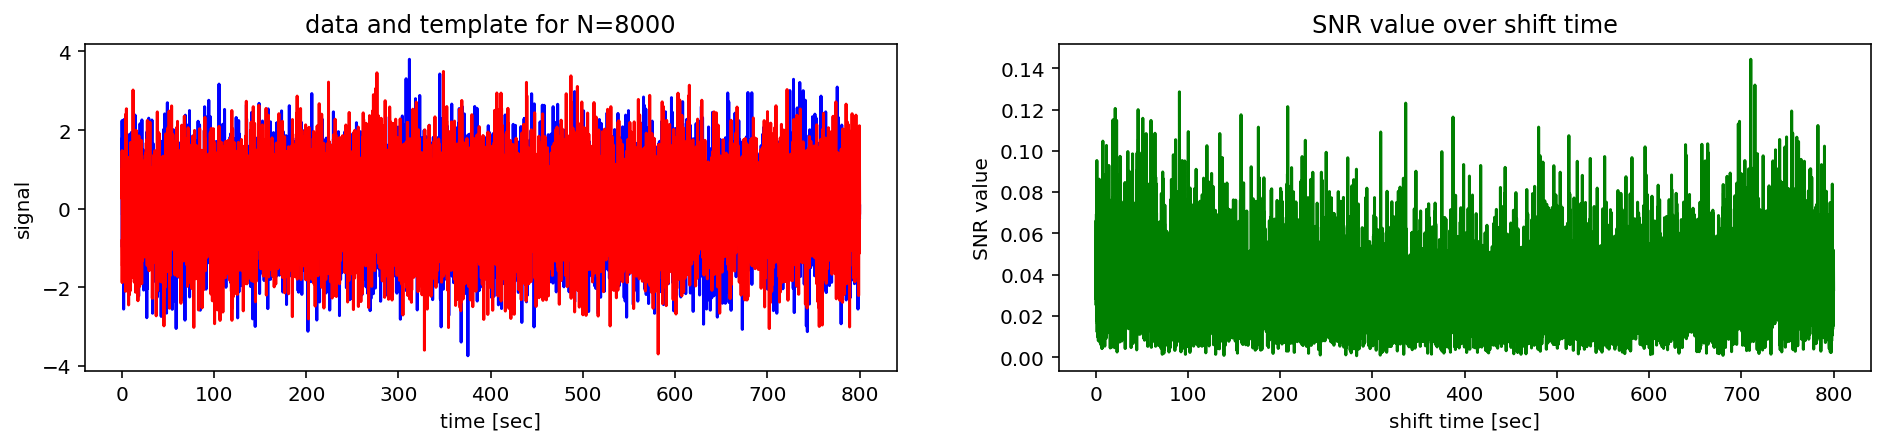

In [42]:
N = 80
data, times = data_noisy(N, dt=dt)
template_noise = np.random.normal(0, 1, len(times))
snr2 = match(data, template_noise, dt)

N = 800
data, times = data_noisy(N, dt=dt)
template_noise = np.random.normal(0, 1, len(times))
snr2 = match(data, template_noise, dt)

N = 8000
data, times = data_noisy(N, dt=dt)
template_noise = np.random.normal(0, 1, len(times))
snr2 = match(data, template_noise, dt)

Y el valor obtenido vuelve a diferir. Otro caso es cuando el template es exactamente la señal, nuevamente no tiene sentido, pero esto vendria siendo un caso limite del buscado (el mejor template que describe mi señal). obtengo:

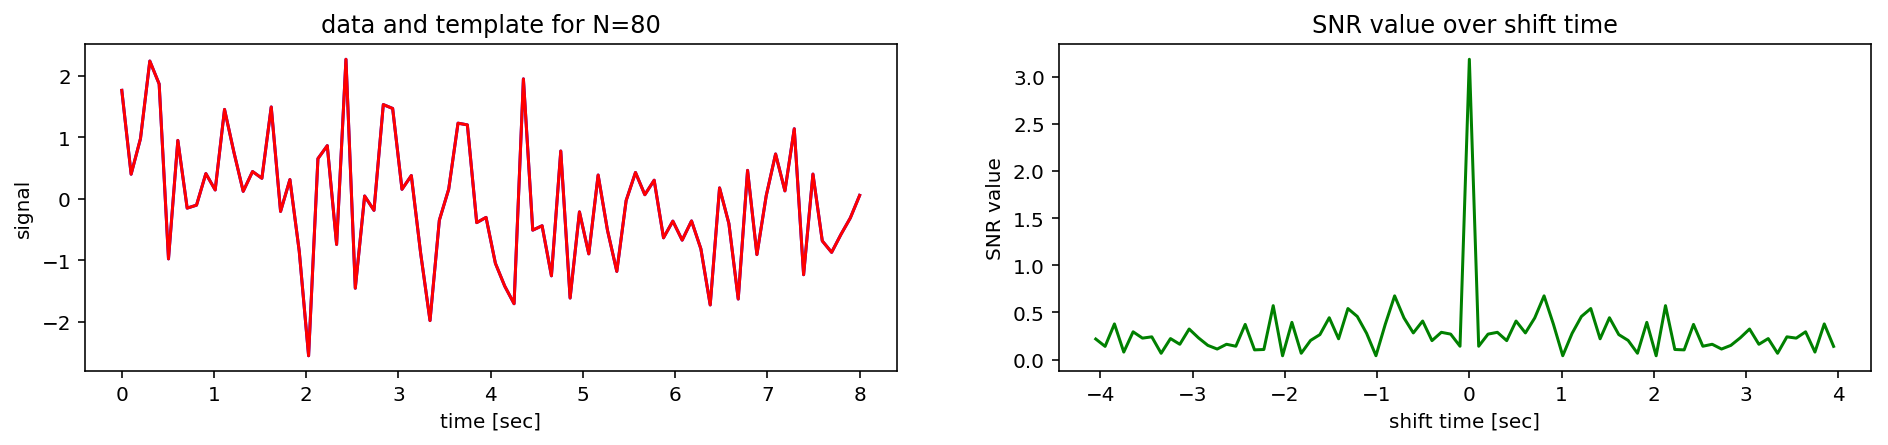

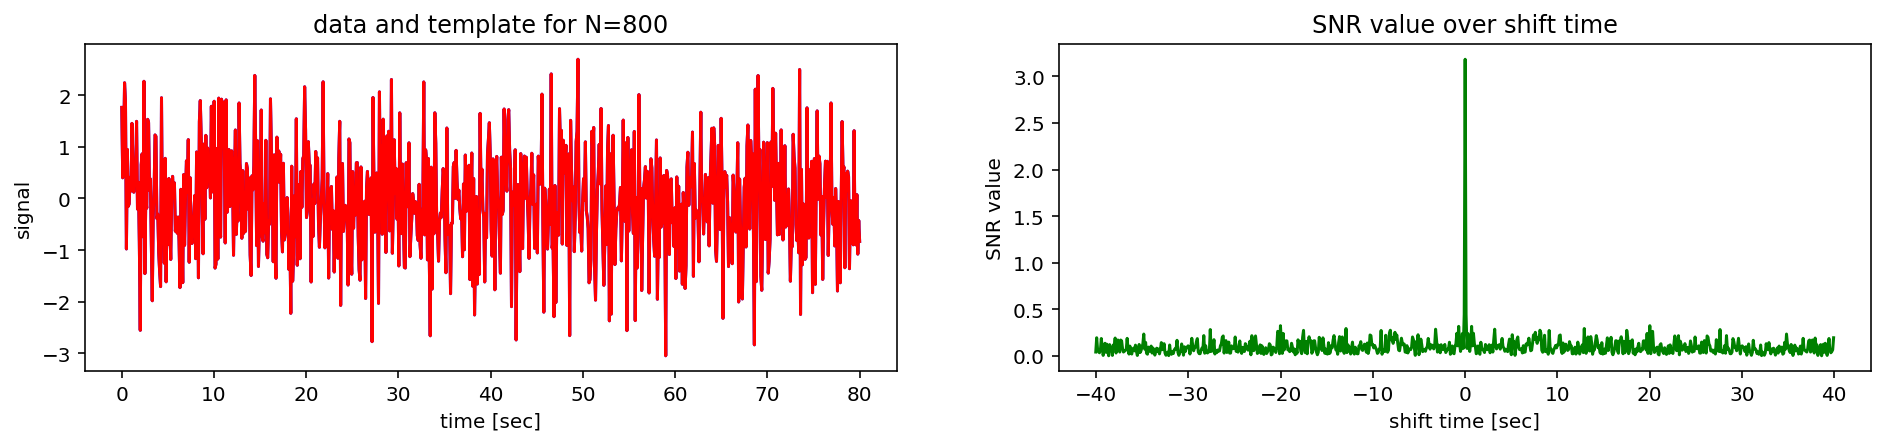

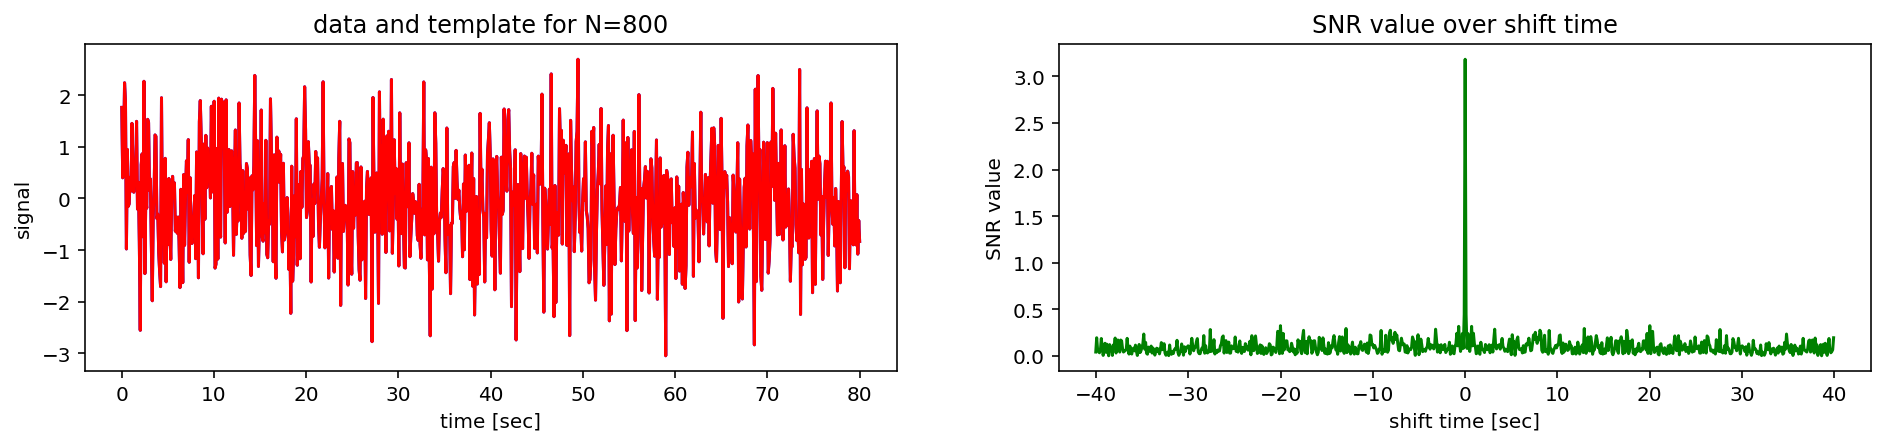

In [43]:
N = 80
data, times = data_noisy(N, dt=dt)
template_noise = data
snr31 = match(data, template_noise, dt, shift=True)

N = 800
data, times = data_noisy(N, dt=dt)
template_noise = data
snr32 = match(data, template_noise, dt, shift=True)

N = 800
data, times = data_noisy(N, dt=dt)
template_noise = data
snr33 = match(data, template_noise, dt, shift=True)

Para este caso limite, ocurre el match a un instante dado que es cuando ambas señales coinciden, esto coincide con lo esperado de obtener SNR muy bajos en shifts de tiempo donde no ocurre el match, pero nuevamente no se encuentra normalizado como se esperaria, de obtener valores cercanos almenos a 1. Algo destacable es que el peak del SNR es siempre igual:

In [44]:
print("peaks of SNR for N = 90, 900 and 9000, respectively are: {}, {} and {}".format(np.max(snr31), 
                                                                                              np.max(snr32),
                                                                                              np.max(snr33)))

peaks of SNR for N = 90, 900 and 9000, respectively are: 3.183098861837907, 3.183098861837907 and 3.183098861837907


### Testing for White noise + single sinusoid
* we are going to use onle one pulse of sinusoid. Here we expect to obtain a beter SNR for the signal of white noise + sinusoid that for the signal of only white noise.

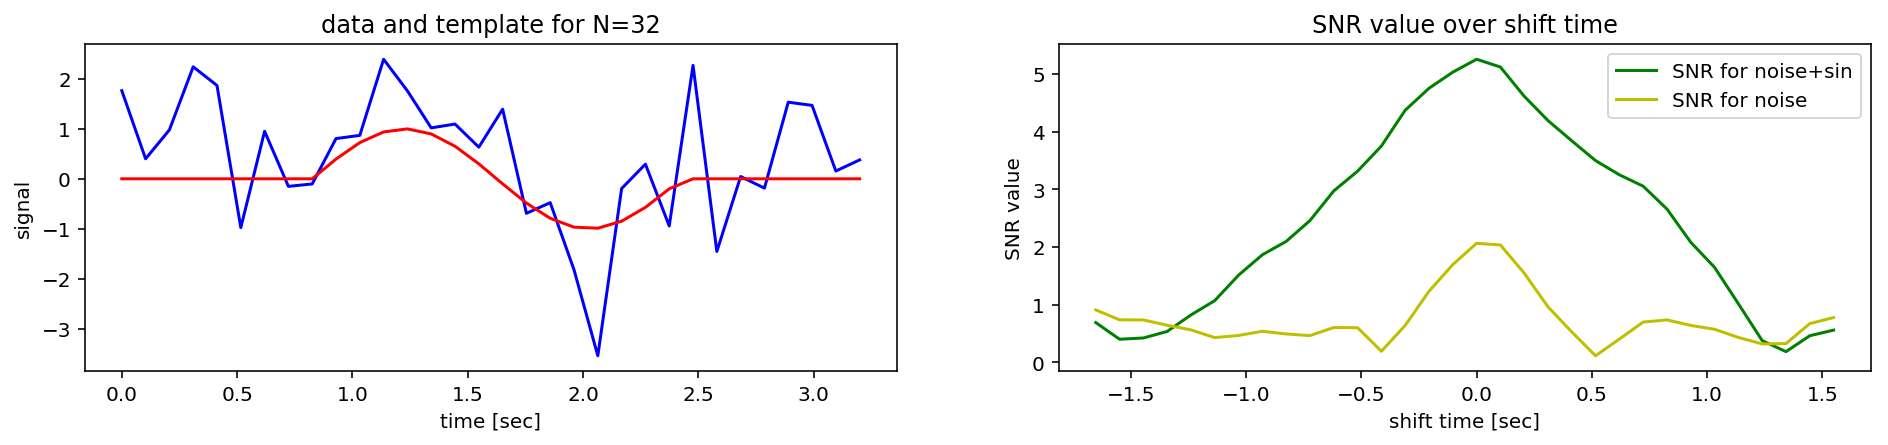

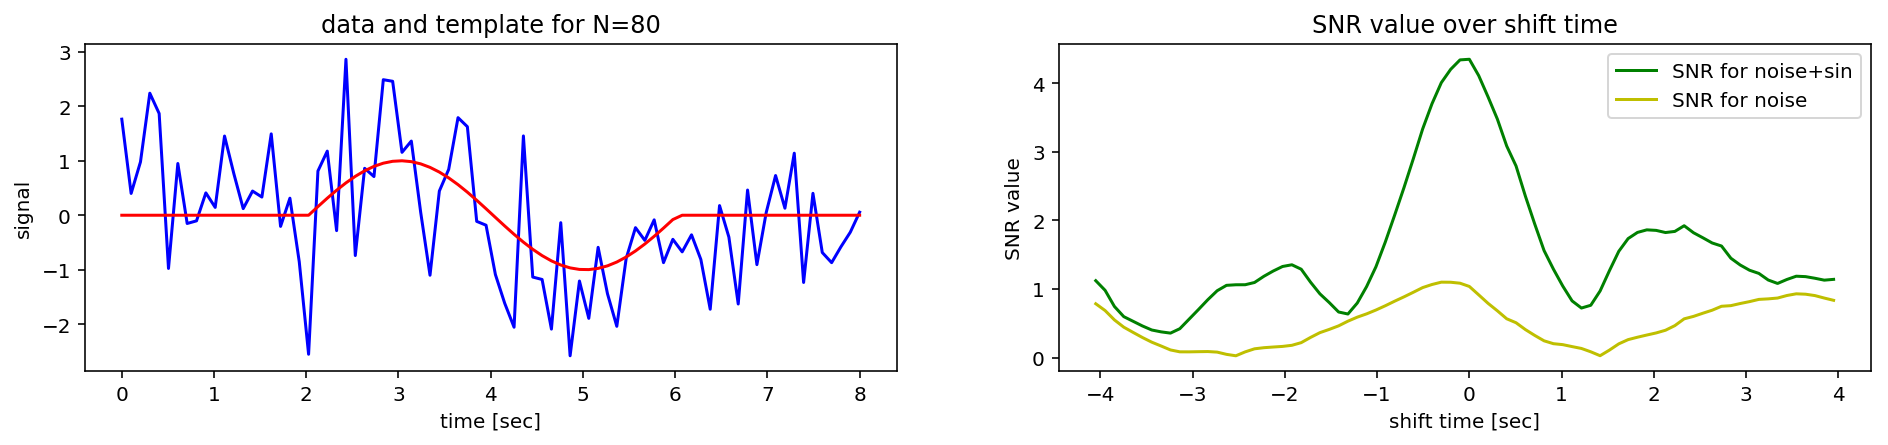

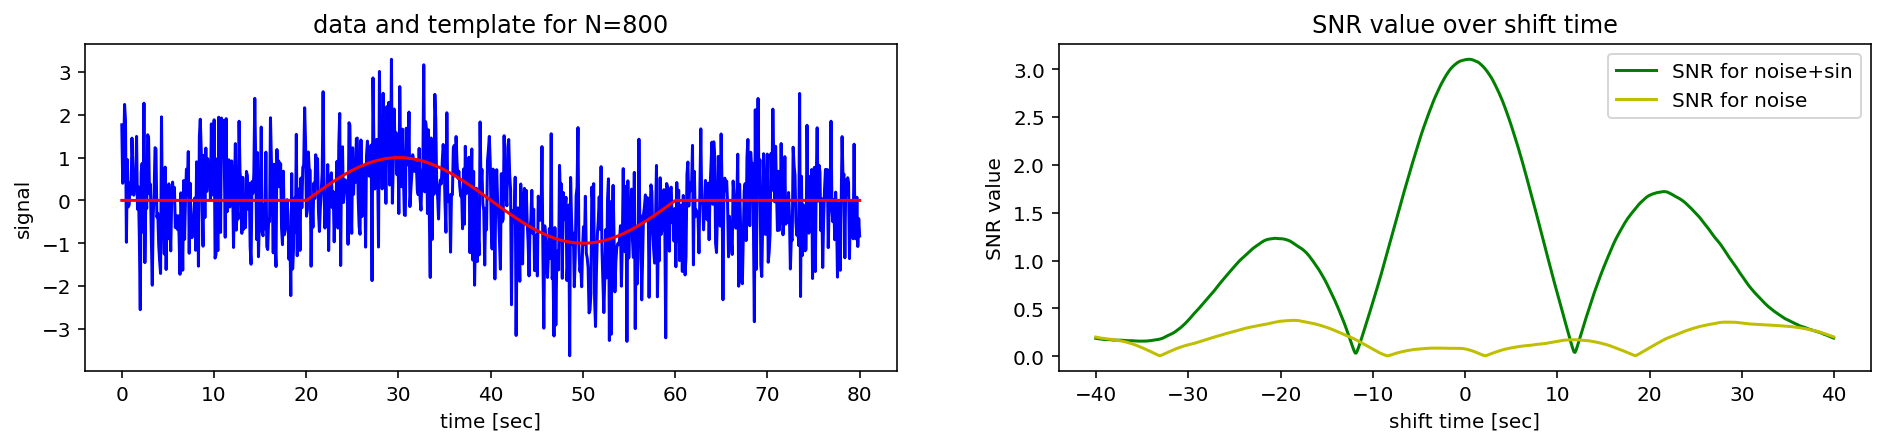

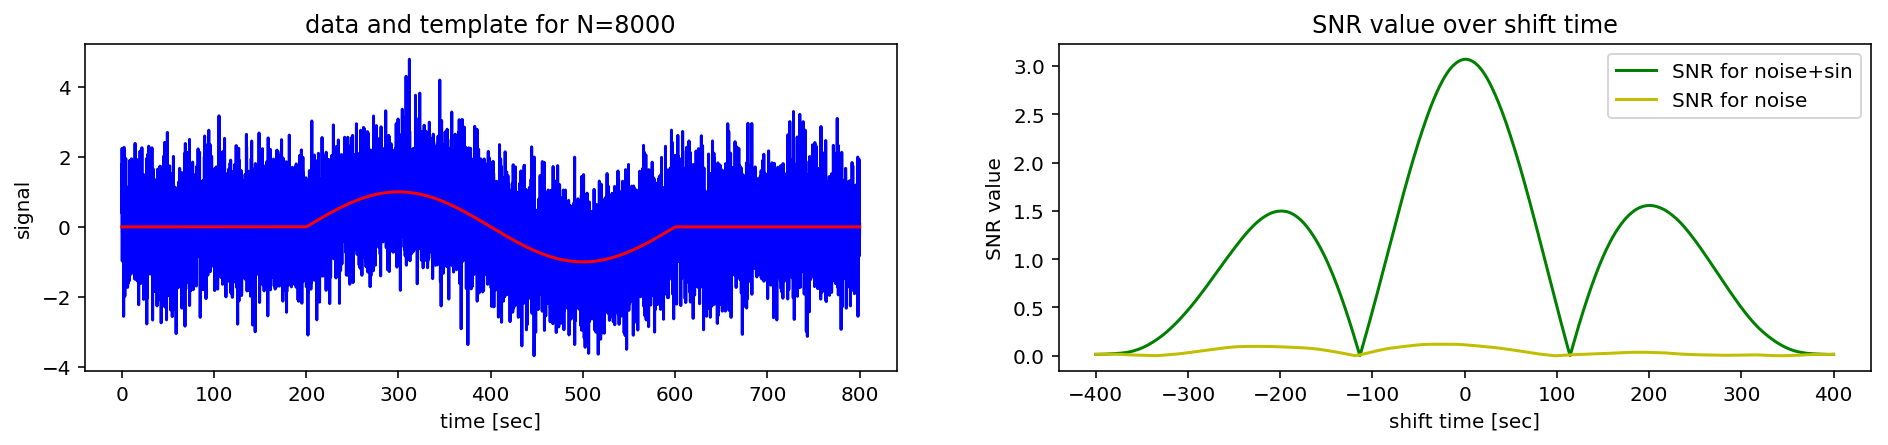

In [46]:
fig0, axis0 = plt.subplots(1, 2, figsize=(16, 3))
N = 32
data01, times = data_noisy(N, dt=dt)
template = get_template(times, [2 / (N * dt)], [1])
data02 = data01 + template
snr02 = match(data02, template, dt, shift=True, axis=axis0, label="SNR for noise+sin")
snr01 = match(data01, template, dt, shift=True, do_plot=False)
axis0[1].plot(times - times[int(len(times)/2)], snr01, 'y', label="SNR for noise")
plt.legend()

fig, axis = plt.subplots(1, 2, figsize=(16, 3))
N = 80
data11, times = data_noisy(N, dt=dt)
template = get_template(times, [2 / (N * dt)], [1])
data12 = data11 + template
snr12 = match(data12, template, dt, shift=True, axis=axis, label="SNR for noise+sin")
snr11 = match(data11, template, dt, shift=True, do_plot=False)
axis[1].plot(times - times[int(len(times)/2)], snr11, 'y', label="SNR for noise")
plt.legend()

fig2, axis2 = plt.subplots(1, 2, figsize=(16, 3))
N = 800
data11, times = data_noisy(N, dt=dt)
template = get_template(times, [2 / (N * dt)], [1])
data12 = data11 + template
snr12 = match(data12, template, dt, shift=True, axis=axis2, label="SNR for noise+sin")
snr11 = match(data11, template, dt, shift=True, do_plot=False)
axis2[1].plot(times - times[int(len(times)/2)], snr11, 'y', label="SNR for noise")
plt.legend()

fig2, axis3 = plt.subplots(1, 2, figsize=(16, 3))
N = 8000
data11, times = data_noisy(N, dt=dt)
template = get_template(times, [2 / (N * dt)], [1])
data12 = data11 + template
snr12 = match(data12, template, dt, shift=True, axis=axis3, label="SNR for noise+sin")
snr11 = match(data11, template, dt, shift=True, do_plot=False)
axis3[1].plot(times - times[int(len(times)/2)], snr11, 'y', label="SNR for noise")
plt.legend()

### Comments (in spanish)
* Aqui vemos algo importante, mas datos entregan un mejor match filter, esto signfica que ES NECESARIO TENER MUCHOS DATOS PARA OBTENER UN SNR CONFIABLE, tambien observamos que cuando señal no coincide con template (para shift time distinto de 0) el valor del SNR baja y  tiende a ser el mismo para ambos casos (solo ruido y ruido mas sinusoide). En este caso el SNR tiene un rango de tiempos en donde entrega valores que pueden considerarse validos, esto es porque la señal en si es bastante amplia, si aplicamos una señal que dura menos en el tiempo obtendremos SNR mas acotadas, por ejemplo:

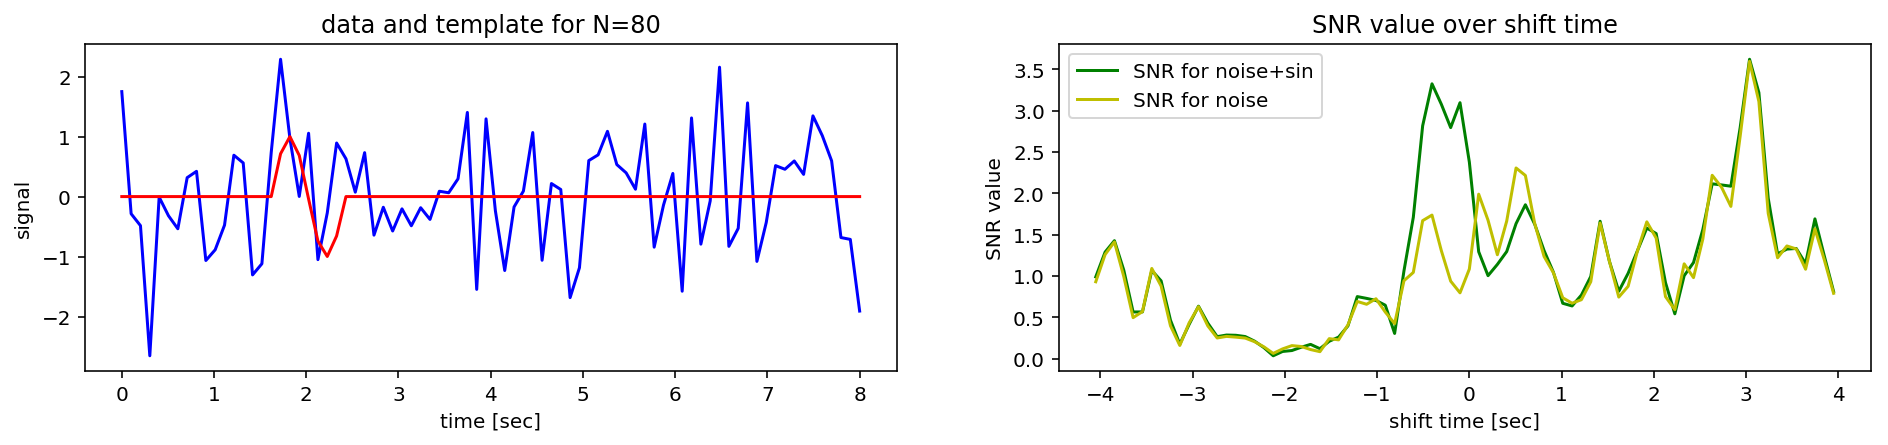

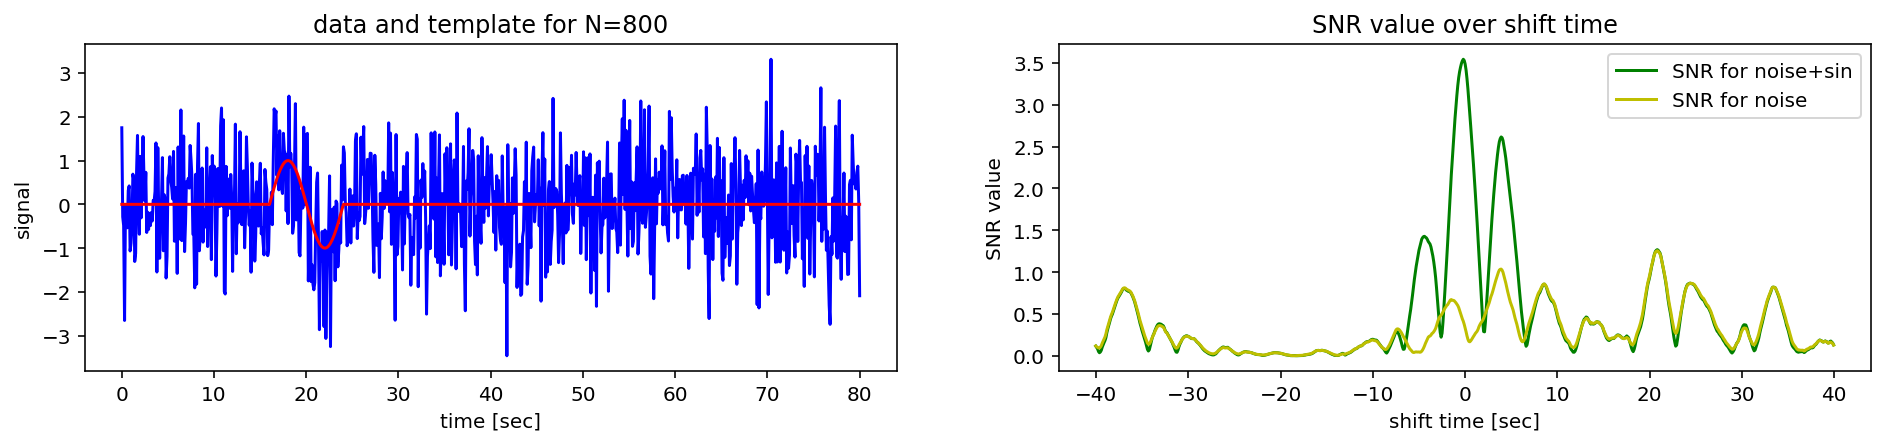

In [51]:
fig0, axis0 = plt.subplots(1, 2, figsize=(16, 3))
N = 80
data01, times = data_noisy(N, dt=dt, seed=11)

l = len(times)
# generate the template
template = np.zeros(l)  
# two options to check template, one completely sinusoidal and another with just one peak
# one peak
template[int(l*2/10): int(l*3/10)] = Signal(frequencies=[10 / (N * dt)], weights=[1]).sin_samples(times[0:int(l*1/10)], 
                                                                                     with_noise=False)
    

data02 = data01 + template
snr02 = match(data02, template, dt, shift=True, axis=axis0, label="SNR for noise+sin")
snr01 = match(data01, template, dt, shift=True, do_plot=False)
axis0[1].plot(times - times[int(len(times)/2)], snr01, 'y', label="SNR for noise")
plt.legend()


fig, axis = plt.subplots(1, 2, figsize=(16, 3))
N = 800
data1, times = data_noisy(N, dt=dt, seed=11)

l = len(times)
# generate the template
template = np.zeros(l)  
# two options to check template, one completely sinusoidal and another with just one peak
# one peak
template[int(l*2/10): int(l*3/10)] = Signal(frequencies=[10 / (N * dt)], weights=[1]).sin_samples(times[0:int(l*1/10)], 
                                                                                     with_noise=False)
    

data2 = data1 + template
snr2 = match(data2, template, dt, shift=True, axis=axis, label="SNR for noise+sin")
snr1 = match(data1, template, dt, shift=True, do_plot=False)
axis[1].plot(times - times[int(len(times)/2)], snr1, 'y', label="SNR for noise")
plt.legend()